In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_c/test/ind.csv
/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_c/test/tat.csv
/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_c/test/swe.csv
/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_c/test/afr.csv
/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_c/test/xho.csv
/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_c/test/amh.csv
/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_c/test/ptbr.csv
/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_c/test/mar.csv
/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_c/test/eng.csv
/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_c/test/yor.csv
/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_c/test/hau.csv
/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_c/test/som.csv
/kaggle/input/semeval-2025-

# Install Libraries and Modules

In [63]:
import warnings
warnings.filterwarnings('ignore') 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import wandb

In [3]:
!pip uninstall -y wandb

Found existing installation: wandb 0.19.1
Uninstalling wandb-0.19.1:
  Successfully uninstalled wandb-0.19.1


In [4]:
!pip install wandb==0.17.5 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 58.6 MB/s eta 0:00:0000:0100:01


In [5]:
!wandb offline
!wandb disabled

W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.
W&B disabled.


In [25]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [6]:
!pip install datasets transformers evaluate sentencepiece accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [27]:
train_afr = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_a/train/afr.csv")
train_arq = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_a/train/arq.csv")
train_hin = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_a/train/hin.csv")
train_swe = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_a/train/swe.csv")


dev_afr = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_a/dev/afr.csv")
dev_arq = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_a/dev/arq.csv")
dev_hin = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_a/dev/hin.csv")
dev_swe = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_a/dev/swe.csv")


test_afr = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_a/test/afr.csv")
test_arq = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_a/test/arq.csv")
test_hin = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_a/test/hin.csv")
test_swe = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_a/test/swe.csv")

# AFRIKAANS

## Sources:
- https://aclanthology.org/2020.lrec-1.301/
- https://github.com/castorini/afriberta

In [5]:
train_afr.head()

,id,text,anger,disgust,fear,joy,sadness
0,afr_train_track_a_00001,Die grondeienaars het die departement genader ...,0,0,0,0,0
1,afr_train_track_a_00002,Dit is verder 'n erkende feit dat daar menings...,0,0,0,0,0
2,afr_train_track_a_00003,Baie families in die Wes-Kaap is in rou gedomp...,0,0,0,0,1
3,afr_train_track_a_00004,Ons wil u deelmaak van die werk wat ons doen.,0,0,0,1,0
4,afr_train_track_a_00005,En dit onderstreep waarom NALN en NELM gesamen...,0,0,0,1,0


In [5]:
train_afr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222 entries, 0 to 1221
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1222 non-null   object
 1   text     1222 non-null   object
 2   anger    1222 non-null   int64 
 3   disgust  1222 non-null   int64 
 4   fear     1222 non-null   int64 
 5   joy      1222 non-null   int64 
 6   sadness  1222 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 67.0+ KB


In [25]:
dev_afr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       98 non-null     object
 1   text     98 non-null     object
 2   anger    98 non-null     int64 
 3   disgust  98 non-null     int64 
 4   fear     98 non-null     int64 
 5   joy      98 non-null     int64 
 6   sadness  98 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 5.5+ KB


<Axes: >

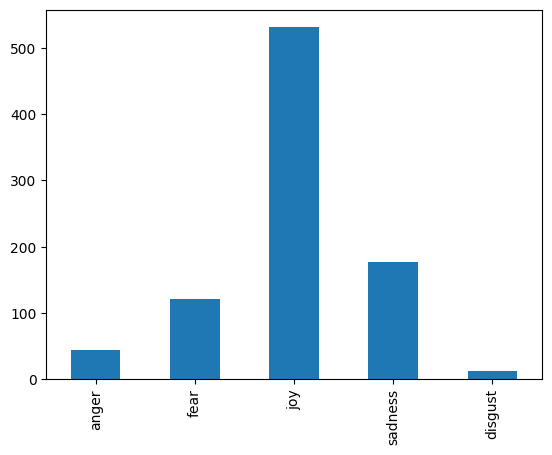

In [17]:
attributes = ['anger', 'fear', 'joy', 'sadness', 'disgust']
train_afr[attributes].sum().plot.bar()

<Axes: >

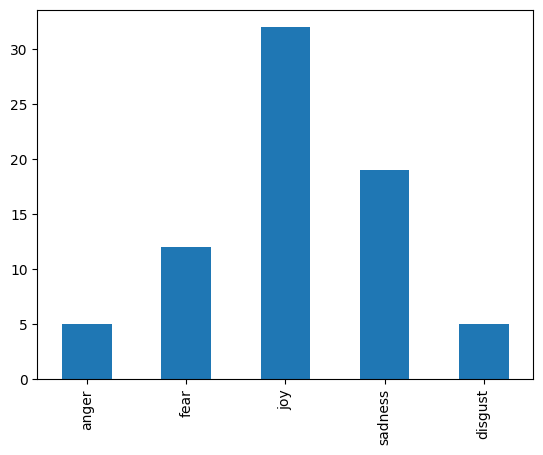

In [18]:
dev_afr[attributes].sum().plot.bar()

In [33]:
test_afr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1065 non-null   object 
 1   text     1065 non-null   object 
 2   anger    0 non-null      float64
 3   disgust  0 non-null      float64
 4   fear     0 non-null      float64
 5   joy      0 non-null      float64
 6   sadness  0 non-null      float64
dtypes: float64(5), object(2)
memory usage: 58.4+ KB


In [34]:
test_afr.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,text,anger,disgust,fear,joy,sadness
0,afr_test_track_a_00001,As regering is ons daartoe verbind om ons deel...,NaN,NaN,NaN,NaN,NaN
1,afr_test_track_a_00002,Op die oomblik is die kwessie van voedselsekur...,NaN,NaN,NaN,NaN,NaN
2,afr_test_track_a_00003,Ek hoor dikwels mense sê hulle is gereed om be...,NaN,NaN,NaN,NaN,NaN
3,afr_test_track_a_00004,Hiervan bly kindermishandeling waarskynlik een...,NaN,NaN,NaN,NaN,NaN
4,afr_test_track_a_00005,So gaan ons ernstig kyk na die kwaliteit van o...,NaN,NaN,NaN,NaN,NaN


https://huggingface.co/FacebookAI/xlm-roberta-base

In [10]:
emotion_labels = ["anger", "disgust", "fear", "joy", "sadness"]

In [11]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('FacebookAI/xlm-roberta-base',
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(emotion_labels))

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Tokenizer function
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

In [39]:
# Encode datasets
def encode_data(df, tokenizer):
    encodings = tokenizer(list(df['text']), truncation=True, padding=True, max_length=128)
    labels = df[['anger', 'disgust', 'fear', 'joy', 'sadness']].fillna(0).values
    return encodings, labels

In [40]:
train_encodings, train_labels = encode_data(train_afr, tokenizer)
dev_encodings, dev_labels = encode_data(dev_afr, tokenizer)

In [41]:
# Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

In [42]:
train_dataset = CustomDataset(train_encodings, train_labels)
dev_dataset = CustomDataset(dev_encodings, dev_labels)

In [48]:
train_dataset

In [ ]:
train_dataset.encodings

In [34]:
def calculate_token_lengths(texts, tokenizer):
    token_lengths = [len(tokenizer.encode(text, truncation=False)) for text in texts]
    return token_lengths

# Calculate token lengths for your datasets
train_lengths = calculate_token_lengths(train_afr['text'], tokenizer)
dev_lengths = calculate_token_lengths(dev_afr['text'], tokenizer)
test_lengths = calculate_token_lengths(test_afr['text'], tokenizer)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


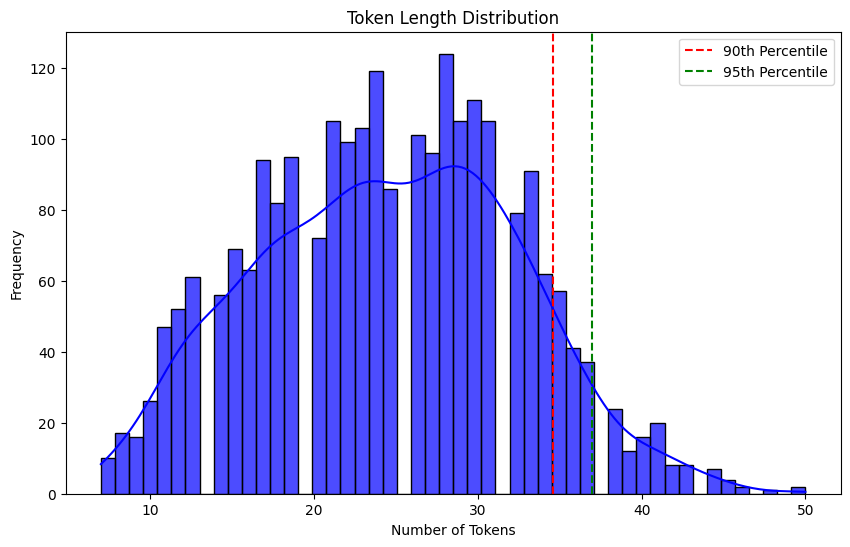

In [38]:
# Combine lengths from all datasets for a global view
all_lengths = train_lengths + dev_lengths + test_lengths

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(all_lengths, bins=50, kde=True, color='blue', alpha=0.7)
plt.axvline(x=np.percentile(all_lengths, 90), color='red', linestyle='--', label='90th Percentile')
plt.axvline(x=np.percentile(all_lengths, 95), color='green', linestyle='--', label='95th Percentile')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [59]:
# Metrics
def compute_metrics(pred):
    logits, labels = pred
    predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).numpy()
    labels = labels.astype(int)

    # Per-class metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': np.mean(f1),
        'precision': np.mean(precision),
        'recall': np.mean(recall),
    }


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results/afr/xlm-roberta-v3',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.01,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [61]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-61-b6f491bd14cd>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [46]:
from unittest import mock
from unittest.mock import Mock
class Dummy:
    def __enter__(self):
        return Mock()

    def __exit__(self, *args):
        pass

In [64]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.098100,0.440667,0.469388,0.396627,0.416754,0.383562
1000,0.055500,0.495828,0.479592,0.455797,0.475190,0.438356
1500,0.021200,0.548567,0.510204,0.480349,0.534202,0.438356
2000,0.012700,0.558691,0.500000,0.464020,0.540268,0.410959
2500,0.011600,0.586781,0.520408,0.504766,0.530266,0.493151
3000,0.008400,0.606210,0.500000,0.465225,0.540842,0.410959
3500,0.005400,0.610927,0.530612,0.496045,0.551364,0.465753


In [ ]:
# Evaluate on dev set
dev_results = trainer.predict(dev_dataset)

# Plot confusion matrix
predictions = (torch.sigmoid(torch.tensor(dev_results.predictions)) > 0.5).numpy()
conf_matrix = confusion_matrix(dev_labels.ravel(), predictions.ravel())

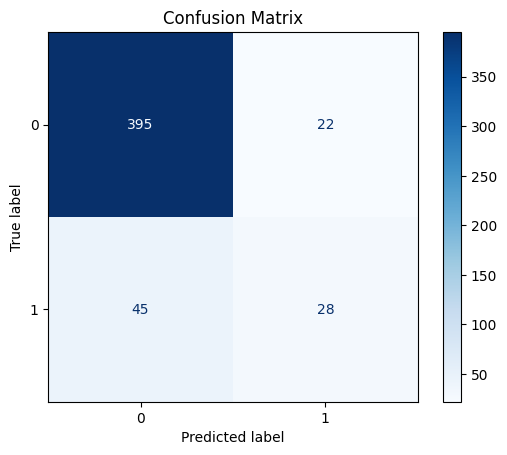

In [67]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

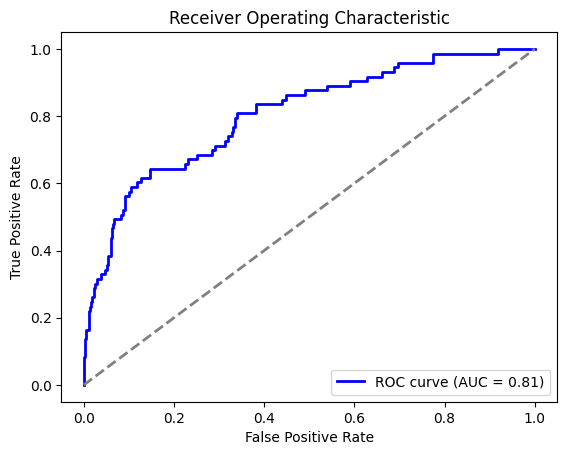

In [68]:
# ROC curve and AUC
fpr, tpr, _ = roc_curve(dev_labels.ravel(), dev_results.predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [69]:
# Print metrics for each class
precision, recall, f1, _ = precision_recall_fscore_support(
    dev_labels, predictions, average=None
)
accuracy = accuracy_score(dev_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
for i, label in enumerate(['anger', 'disgust', 'fear', 'joy', 'sadness']):
    print(f"{label}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

Accuracy: 0.4694
anger: Precision=0.0000, Recall=0.0000, F1=0.0000
disgust: Precision=0.0000, Recall=0.0000, F1=0.0000
fear: Precision=0.0000, Recall=0.0000, F1=0.0000
joy: Precision=0.6538, Recall=0.5312, F1=0.5862
sadness: Precision=0.5000, Recall=0.5789, F1=0.5366


In [72]:
# Predict on test set
test_encodings = tokenizer(list(test_afr['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_afr), 5)))  # Dummy labels for test
test_results = trainer.predict(test_dataset)
test_predictions = (torch.sigmoid(torch.tensor(test_results.predictions)) > 0.5).numpy()

# Save predictions
test_afr[['anger', 'disgust', 'fear', 'joy', 'sadness']] = test_predictions
test_afr.to_csv('test_predictions_afr_xlm_roberta_v1.csv', index=False)